In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from nanonets.topology import NanoparticleTopology
from nanonets.electrostatic import NanoparticleElectrostatic

def display_packed_structure(pos_after, radius_vals):
    
    fig = plt.figure()
    ax  = fig.add_subplot()
    bou = np.max(np.abs(np.array(list(pos_after.values())))) + np.max(radius_vals)
    for key, val in pos_after.items():
        if key >= 0:
            circle_ = plt.Circle((val[0],val[1]),radius_vals[key])
        else:
            circle_ = plt.Circle((val[0],val[1]),10.0)
        ax.add_patch(circle_)
    ax.set_aspect('equal')
    ax.set_xlim(-bou*1.2, bou*1.2)
    ax.set_ylim(-bou*1.2, bou*1.2)
    ax.axis('off')

### Lattice

In [2]:
sim_c       = NanoparticleElectrostatic()
L           = 9
N_e         = 8
e_pos       = [[0,0], [int((L-1)/2),0],[L-1,0], [0,int((L-1)/2)],[0,L-1],[L-1,int((L)/2)],[int((L)/2),(L-1)],[L-1,L-1]]
mean_r1     = 10.0

sim_c.lattice_network(L, L)
sim_c.add_electrodes_to_lattice_net(e_pos)
sim_c.init_nanoparticle_radius(mean_r1)
radius_vals = sim_c.get_radius()
pos_before  = sim_c.get_positions()
sim_c.pack_lattice()
pos_after   = sim_c.get_positions()

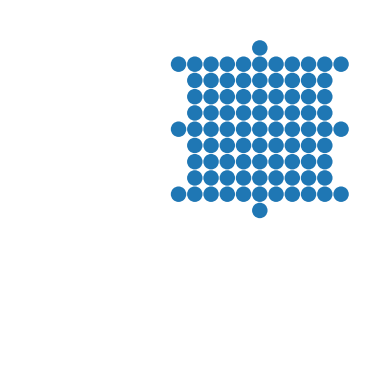

In [3]:
display_packed_structure(pos_after, radius_vals)

### Disorderd Network / Fixed Radius

In [4]:
def create_packing_graph(positions, radii, d_min, delta):
    """
    Creates a directed graph from circle packing positions.
    Nodes are connected if their physical distance is within a tolerance range.
    
    Args:
        positions (dict): {index: [x, y]} output from the packing function.
        radii (array-like): List of radii corresponding to indices.
        d_min (float): The minimum buffer used in packing.
        delta (float): Connection tolerance. 
                       Two particles connect if dist < (r_i + r_j + d_min + delta).
                       
    Returns:
        nx.DiGraph: A directed graph with N nodes.
    """
    N = len(radii)
    G = nx.DiGraph()
    
    # 1. Add all nodes explicitly (in case some have no connections)
    # We can store attributes like position and radius in the node for later use
    for i in range(N):
        G.add_node(i, pos=positions[i], radius=radii[i])
    
    # 2. Check all pairs for connections
    # We loop j > i to avoid duplicate checks, then add edges in both directions
    for i in range(N):
        pos_i = np.array(positions[i])
        r_i = radii[i]
        
        for j in range(i + 1, N):
            pos_j = np.array(positions[j])
            r_j = radii[j]
            
            # Calculate Euclidean distance
            dist = np.linalg.norm(pos_i - pos_j)
            
            # The Connection Condition
            # "Touching" logic: Sum of radii + Buffer + Tolerance
            contact_threshold = r_i + r_j + d_min + delta
            
            if dist <= contact_threshold:
                # Add directed edges both ways (symmetric connection)
                G.add_edge(i, j)
                G.add_edge(j, i)
                
    return G

In [ ]:
sim_c       = NanoparticleElectrostatic()
N_p         = 81
N_e         = 8
e_pos       = [[-1,-1],[0,-1],[1,-1],[-1,0],[1,0],[-1,1],[0,1],[1,1]]
mean_r1     = 10.0

sim_c.random_network(N_p)
sim_c.add_electrodes_to_random_net(e_pos)
sim_c.init_nanoparticle_radius(mean_r1)
radius_vals = sim_c.get_radius()
pos_before  = sim_c.get_positions()
sim_c.pack_circles()
sim_c.create_packing_graph()
pos_after   = sim_c.get_positions()
G_after     = sim_c.get_graph()

In [24]:
1e-6/(2*np.pi*3*1e-9)

53.05164769729844

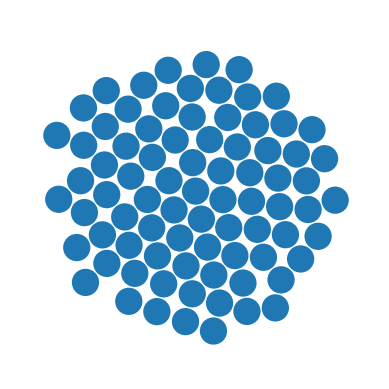

In [6]:
display_packed_structure(pos_after, radius_vals)

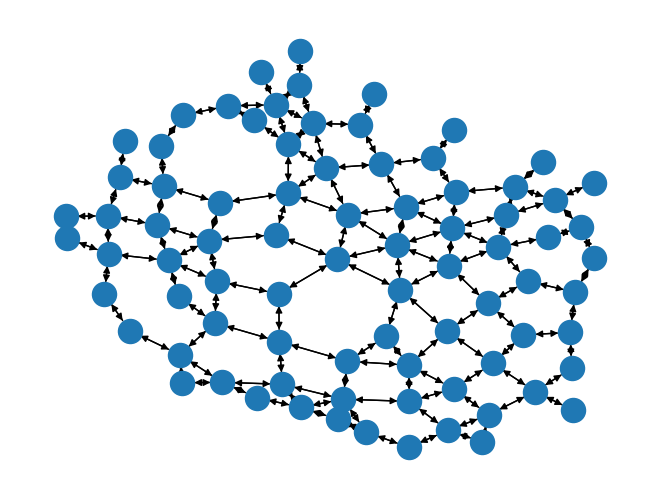

In [17]:
nx.draw(G_after)

### Disorderd Network / Radius Disorder

In [46]:
# Network Params
sim_c       = NanoparticleElectrostatic()
N_p         = 81
N_e         = 8
e_pos       = [[-1,-1],[0,-1],[1,-1],[-1,0],[1,0],[-1,1],[0,1],[1,1]]
mean_r1     = 10.0
mean_r2     = 80.0
N_mean_r2   = N_p // 3

# Packing Params
initial_temp = 0.0
k_attract    = 0.1
start_cutoff = 100.0
iterations   = 20000

sim_c.random_network(N_p)
sim_c.add_electrodes_to_random_net(e_pos)
sim_c.init_nanoparticle_radius(mean_r1)
sim_c.update_nanoparticle_radius_at_random(N_mean_r2, mean_r2)
radius_vals = sim_c.get_radius()
pos_before  = sim_c.get_positions()
sim_c.pack_circles(iterations=iterations, initial_temp=initial_temp, k_attract=k_attract, start_cutoff=start_cutoff)
pos_after   = sim_c.get_positions()

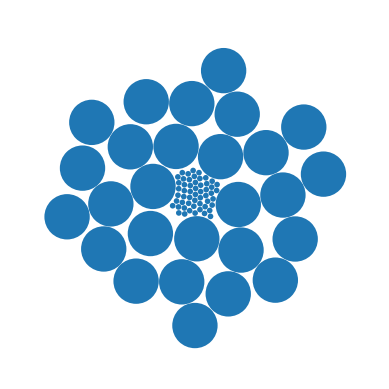

In [47]:
display_packed_structure(pos_after, radius_vals)